In [138]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import sys
from pathlib import Path
print(str(Path().resolve().parent))
sys.path.append(str(Path().resolve().parent))

import os
import h5py
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from typing import List, Dict, Union, Tuple, Optional
from pathlib import Path

from Data.data_class import plot_electron_spectrogram
from data_loader import MagnetotailDataset
from autoencoder_params import Autoencoder, AnomalyTransformer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
C:\Users\ianma\OneDrive\Documents\Thesis\Magnetotail-Boundary-with-ML


In [39]:
file_path = Path('..') / "Data" / "training_data" / "test.h5"
abs_file_path = file_path.resolve()

# Create dataset
dataset = MagnetotailDataset(abs_file_path)


In [32]:
dataset[0, :].keys()

dict_keys(['time', 'session_id', 'B_electron_avgtemp', 'B_electron_density', 'B_electron_eflux', 'B_electron_velocity_gsm', 'B_electron_vthermal', 'B_ion_avgtemp', 'B_ion_density', 'B_ion_eflux', 'B_ion_velocity_gsm', 'B_ion_vthermal', 'B_magnetic_field_gsm', 'times'])

In [40]:
# Create a list of cutoff times for training
initial_cutoff_list = ['2011-08-14 22:50:00', 
                       '2011-11-12 05:40:00',
                       '2011-11-13 01:00:00',
                       '2011-11-13 22:00:00',
                       '2011-08-17 08:00:00',
                       '2011-08-16 01:10:00',
                       '2011-09-13 17:00:00',
                       '2011-09-14 13:15:00',
                       '2011-09-14 23:00:00',
                       '2012-02-09 11:00:00',
                       '2012-05-03 23:00:00', 
                       '2012-11-30 10:30:00',
                       ]
final_cutoff_list = ['2011-08-15 18:30:00',
                     '2011-11-12 06:40:00',
                     '2011-11-13 04:30:00',
                     '2011-11-13 23:30:00',
                     '2011-08-17 09:00:00',
                     '2011-08-16 02:30:00',
                     '2011-09-13 21:00:00',
                     '2011-09-14 14:15:00',
                     '2011-09-15 00:30:00',
                     '2012-02-09 14:00:00',
                     '2012-05-04 07:00:00',
                     '2012-11-30 12:00:00',
                     ]


# Assing the trainable times to the dataset
dataset.exclude_time_ranges(initial_cutoffs=initial_cutoff_list,
                           final_cutoffs=final_cutoff_list
                           )

In [66]:
trainable_data = dataset.get_trainable_samples()

In [104]:
encoder = Autoencoder(n_features=16, latent_dim=12)

In [86]:
trainable_samples, test_samples = encoder.prepare_data(trainable_data, test_ratio=0.1)

In [87]:
trainable_samples['all_features'].shape

torch.Size([2636, 48])

In [105]:
encoder = encoder.fit(trainable_samples['all_features'], test_samples['all_features'], lr=0.0005, batch_size=256, epochs=500)

Epoch [5/500], Loss: 0.9886, Test Loss: 0.8959
Epoch [10/500], Loss: 0.7460, Test Loss: 0.7046
Epoch [15/500], Loss: 0.6193, Test Loss: 0.6153
Epoch [20/500], Loss: 0.5185, Test Loss: 0.5822
Epoch [25/500], Loss: 0.4312, Test Loss: 0.5578
Epoch [30/500], Loss: 0.3760, Test Loss: 0.5250
Epoch [35/500], Loss: 0.3309, Test Loss: 0.4948
Epoch [40/500], Loss: 0.2985, Test Loss: 0.4690
Epoch [45/500], Loss: 0.2752, Test Loss: 0.4497
Epoch [50/500], Loss: 0.2596, Test Loss: 0.4334
Epoch [55/500], Loss: 0.2474, Test Loss: 0.4178
Epoch [60/500], Loss: 0.2328, Test Loss: 0.4087
Epoch [65/500], Loss: 0.2237, Test Loss: 0.3982
Epoch [70/500], Loss: 0.2149, Test Loss: 0.3930
Epoch [75/500], Loss: 0.2098, Test Loss: 0.3839
Epoch [80/500], Loss: 0.2029, Test Loss: 0.3823
Epoch [85/500], Loss: 0.1923, Test Loss: 0.3781
Epoch [90/500], Loss: 0.1869, Test Loss: 0.3784
Epoch [95/500], Loss: 0.1837, Test Loss: 0.3734
Epoch [100/500], Loss: 0.1773, Test Loss: 0.3667
Epoch [105/500], Loss: 0.1707, Test Loss

In [124]:
file_path = Path('..') / "Data" / "testing_data" / "test.h5"
abs_file_path = file_path.resolve()

# Create dataset
testing_dataset = MagnetotailDataset(abs_file_path)

In [ ]:
testing_data, _ = encoder.prepare_data(testing_dataset.get_trainable_samples(), test_ratio=0)

In [ ]:
testing_data['all_features'].shape

torch.Size([536, 48])

Mean Reconstruction Error: 0.385943
Standard Deviation: 1.519114
Max Error: 21.013466
Min Error: 0.035052


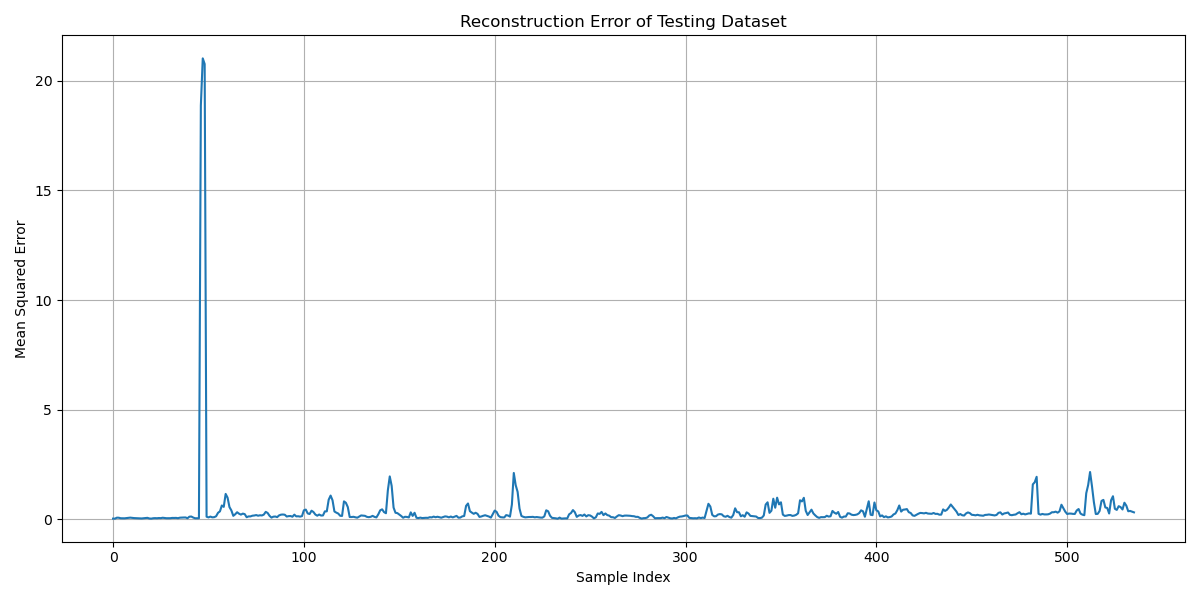

In [ ]:
# Get the original and reconstructed data
with torch.no_grad():
    reconstructed = encoder(testing_data['all_features'])
    
# Calculate reconstruction error (mean squared error)
reconstruction_error = torch.mean((testing_data['all_features'] - reconstructed) ** 2, dim=1)

# Plot the reconstruction error
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(reconstruction_error.cpu().numpy())
plt.title('Reconstruction Error of Testing Dataset')
plt.xlabel('Sample Index')
plt.ylabel('Mean Squared Error')
plt.grid(True)
plt.tight_layout()

# Calculate and display statistics
mean_error = torch.mean(reconstruction_error).item()
std_error = torch.std(reconstruction_error).item()
max_error = torch.max(reconstruction_error).item()
min_error = torch.min(reconstruction_error).item()

print(f"Mean Reconstruction Error: {mean_error:.6f}")
print(f"Standard Deviation: {std_error:.6f}")
print(f"Max Error: {max_error:.6f}")
print(f"Min Error: {min_error:.6f}")

In [139]:
transformer = AnomalyTransformer(n_features=16)

In [146]:
trainable_samples, test_samples = transformer.prepare_data(trainable_data, test_ratio=0.1)

In [149]:
trainable_samples['all_features'][0, : ,:]

tensor([[-0.3431, -0.3486, -0.4725,  0.6362,  0.0440, -0.4225, -0.4829, -0.4647,
         -0.6104, -0.2882, -0.7494, -0.4238, -0.5106, -0.9343, -0.8724, -0.6262],
        [-0.3764, -0.3105, -0.6497,  0.2383,  0.1649, -0.5107, -0.5388, -0.4361,
         -1.0659,  0.5641, -1.6274, -0.5253,  0.2087,  0.1900,  0.8377, -0.6262],
        [-0.3410, -0.3398, -0.5334,  0.2357, -0.5942, -0.4166, -0.4948, -0.4355,
         -1.0243,  0.1810, -1.1933, -0.4459,  0.0773, -0.7437, -0.8951, -0.6261]])

In [141]:
transformer = transformer.fit(trainable_samples['all_features'], test_samples['all_features'], lr=0.0005, batch_size=256, epochs=150)

Epoch [5/150], Loss: 0.1980, Test Loss: 0.2408
Epoch [10/150], Loss: 0.1265, Test Loss: 0.1790
Epoch [15/150], Loss: 0.1002, Test Loss: 0.1393
Epoch [20/150], Loss: 0.0844, Test Loss: 0.1149
Epoch [25/150], Loss: 0.0774, Test Loss: 0.0997
Epoch [30/150], Loss: 0.0707, Test Loss: 0.0916
Epoch [35/150], Loss: 0.0629, Test Loss: 0.0839
Epoch [40/150], Loss: 0.0576, Test Loss: 0.0797
Epoch [45/150], Loss: 0.0541, Test Loss: 0.0726
Epoch [50/150], Loss: 0.0515, Test Loss: 0.0684
Epoch [55/150], Loss: 0.0477, Test Loss: 0.0648
Epoch [60/150], Loss: 0.0452, Test Loss: 0.0600
Epoch [65/150], Loss: 0.0428, Test Loss: 0.0565
Epoch [70/150], Loss: 0.0400, Test Loss: 0.0532
Epoch [75/150], Loss: 0.0383, Test Loss: 0.0499
Epoch [80/150], Loss: 0.0344, Test Loss: 0.0470
Epoch [85/150], Loss: 0.0341, Test Loss: 0.0452
Epoch [90/150], Loss: 0.0330, Test Loss: 0.0440
Epoch [95/150], Loss: 0.0313, Test Loss: 0.0416
Epoch [100/150], Loss: 0.0299, Test Loss: 0.0411
Epoch [105/150], Loss: 0.0275, Test Loss

In [142]:
testing_data, _ = transformer.prepare_data(testing_dataset.get_trainable_samples(), test_ratio=0)

Mean Reconstruction Error: 0.044284
Standard Deviation: 0.062718
Max Error: 0.416870
Min Error: 0.006291


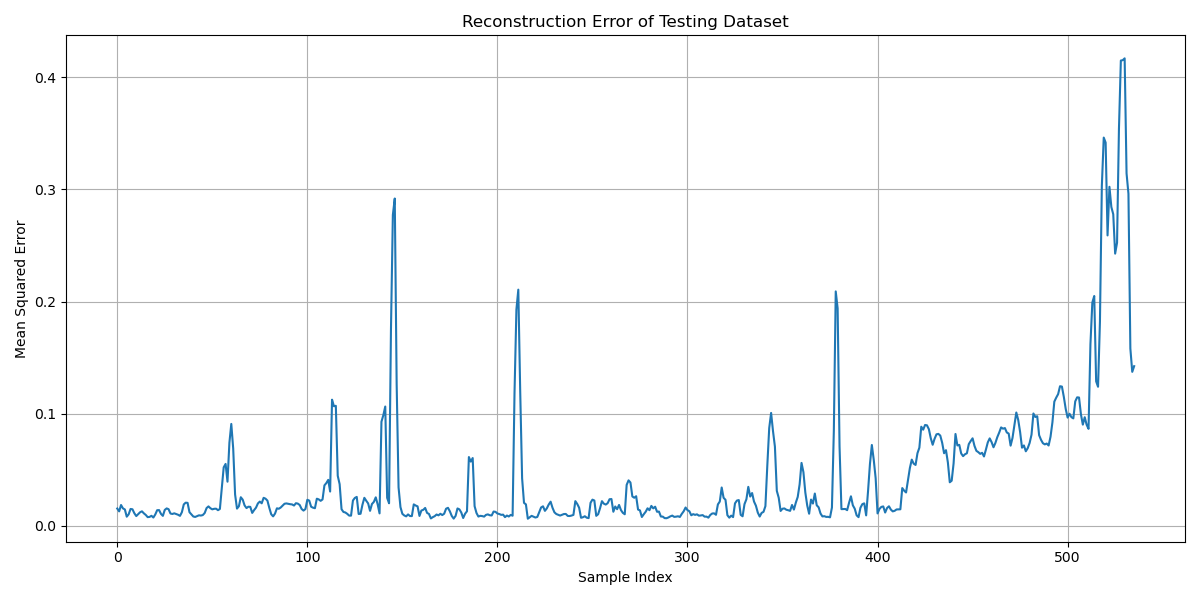

In [143]:
# Get the original and reconstructed data
with torch.no_grad():
    reconstructed = transformer(testing_data['all_features'])
    
# Calculate reconstruction error (mean squared error)
reconstruction_error = torch.mean((testing_data['all_features'] - reconstructed) ** 2, dim=(1, 2))

# Plot the reconstruction error
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(reconstruction_error.cpu().numpy())
plt.title('Reconstruction Error of Testing Dataset')
plt.xlabel('Sample Index')
plt.ylabel('Mean Squared Error')
plt.grid(True)
plt.tight_layout()

# Calculate and display statistics
mean_error = torch.mean(reconstruction_error).item()
std_error = torch.std(reconstruction_error).item()
max_error = torch.max(reconstruction_error).item()
min_error = torch.min(reconstruction_error).item()

print(f"Mean Reconstruction Error: {mean_error:.6f}")
print(f"Standard Deviation: {std_error:.6f}")
print(f"Max Error: {max_error:.6f}")
print(f"Min Error: {min_error:.6f}")

In [144]:
testing_dataset_variables = testing_dataset.get_trainable_samples()


In [135]:
testing_dataset_variables['section_000'].keys()

dict_keys(['time', 'session_id', 'B_electron_avgtemp', 'B_electron_density', 'B_electron_eflux', 'B_electron_velocity_gsm', 'B_electron_vthermal', 'B_ion_avgtemp', 'B_ion_density', 'B_ion_eflux', 'B_ion_velocity_gsm', 'B_ion_vthermal', 'B_magnetic_field_gsm', 'times'])

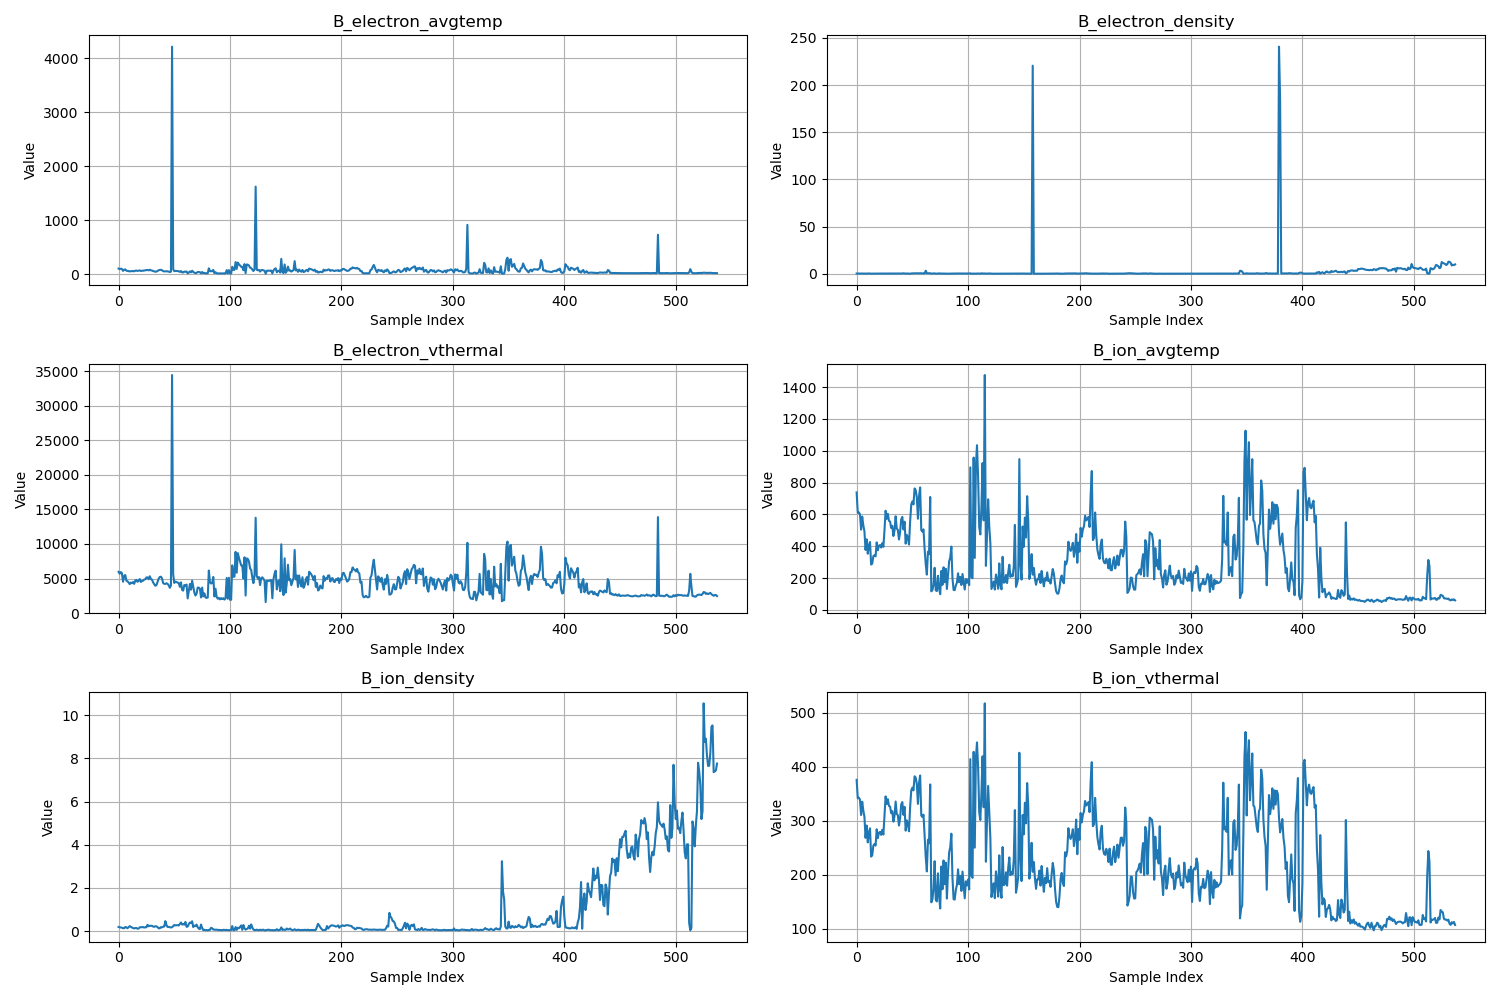

In [151]:
plt.figure(figsize=(15, 10))

# Get the variables to plot
variables_to_plot = ['B_electron_avgtemp', 'B_electron_density', 'B_electron_vthermal', 'B_ion_avgtemp', 'B_ion_density', 'B_ion_vthermal']

# Create subplots for each variable
for i, var_name in enumerate(variables_to_plot, 1):
    plt.subplot(3, 2, i)
    
    # Get the data for this variable (flatten to 1D for plotting)
    data = testing_dataset_variables['section_000'][var_name].squeeze().cpu().numpy()
    
    # Plot against indices
    plt.plot(range(len(data)), data)
    plt.title(f'{var_name}')
    plt.xlabel('Sample Index')
    plt.ylabel('Value')
    plt.grid(True)

plt.tight_layout()
plt.show()